In [1]:
from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import gc
import numpy as np
import pandas as pd
import scipy.sparse as sps
from pathlib import Path, PurePath
import scanpy as sc
import h5py
import scipy.io as sio
import warnings
from muon import atac as ac
import seaborn as sns

from os.path import join
import matplotlib.pyplot as plt

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata


from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import json
import copy
from matplotlib.image import imread
def load_spatial(path, adata, library_id='0'):
    tissue_positions_file = join(path, "tissue_positions.csv")
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=join(path, "scalefactors_json.json"),
        hires_image=join(path, "tissue_hires_image.png"),
        lowres_image=join(path, "tissue_lowres_image.png"),
    )
    
    adata.uns["spatial"] = dict()
    adata.uns["spatial"][library_id] = dict()
    adata.uns["spatial"][library_id]["images"] = dict()
    for res in ["hires", "lowres"]:
        try:
            adata.uns["spatial"][library_id]["images"][res] = imread(
                str(files[f"{res}_image"])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
        Path(files["scalefactors_json_file"]).read_bytes()
    )

    # read coordinates
    positions = pd.read_csv(
        files["tissue_positions_file"],
        header=0 if Path(tissue_positions_file).name == "tissue_positions.csv" else None,
        index_col=0,
    )
    positions.columns = [
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_col_in_fullres",
        "pxl_row_in_fullres",
    ]
    adata.obs = adata.obs.join(positions, how="left")
    adata.obsm["spatial"] = adata.obs[
        ["pxl_row_in_fullres", "pxl_col_in_fullres"]
    ].to_numpy()
   
    adata.obs.drop(
        columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
        inplace=True,
    )

In [3]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

import gzip
from scipy.io import mmread
def load_data(_dir):
    feat_names = pd.read_csv(join(_dir, 'features.tsv.gz'), compression='gzip', sep='\t', header=None)
    barcodes   = pd.read_csv(join(_dir, 'barcodes.tsv.gz'), compression='gzip', sep='\t', header=None)

    with gzip.open(join(_dir, 'matrix.mtx.gz'), 'rb') as gzipped_file:
        mat = mmread(gzipped_file)

    ad = sc.AnnData(sps.csr_matrix(mat.T))
    ad.obs_names = barcodes[0].values
    ad.var_names = feat_names[1].values
    ad.var['id'] = feat_names[0].values
    ad.var['type'] = feat_names[2].values
    return ad

In [4]:
data_dir = '/disco_500t/xuhua/data/spatial_multi_omics/lymp_node/LN-2024-new/outs'

ad3 = load_data(join(data_dir, 'filtered_feature_bc_matrix'))
ad3_rna = ad3[:, ad3.var['type']=='Gene Expression'].copy()
ad3_adt = ad3[:, ad3.var['type']=='Antibody Capture'].copy()
load_spatial(join(data_dir, 'spatial'), ad3_rna)
load_spatial(join(data_dir, 'spatial'), ad3_adt)

ad3_rna.obs['src'] = ad3_adt.obs['src'] = ['s3']*ad3_rna.n_obs
ad3_rna.obs_names = [f's3-{x}' for x in ad3_rna.obs_names]
ad3_adt.obs_names = [f's3-{x}' for x in ad3_adt.obs_names]

ad3_rna.var_names_make_unique()
ad3_adt.var_names_make_unique()

data_dir = '/disco_500t/xuhua/data/spatial_multi_omics/lymp_tonsil_ramen'

ad_a1_rna = sc.read_h5ad(join(data_dir, 'lymph_A1/adata_RNA.h5ad'))
ad_a1_adt = sc.read_h5ad(join(data_dir, 'lymph_A1/adata_ADT.h5ad'))
meta1 = pd.read_csv(join(data_dir, 'lymph_A1/A1_LN_cloupe_Kwoh.csv'), index_col=0) 
ad_a1_rna.obs['lab'] = meta1.loc[ad_a1_rna.obs_names, 'manual'].to_list()
ad_a1_adt.obs['lab'] = meta1.loc[ad_a1_adt.obs_names, 'manual'].to_list()
ad_a1_rna.obs['src'] = ad_a1_adt.obs['src'] = ['s1'] * ad_a1_rna.n_obs
ad_a1_rna.obs_names = [f's1-{x}' for x in ad_a1_rna.obs_names]
ad_a1_adt.obs_names = [f's1-{x}' for x in ad_a1_adt.obs_names]
ad_a1_rna.obs['Sample'] = ad_a1_adt.obs['Sample'] = ['S1']*ad_a1_rna.n_obs
ad_a1_rna.var_names_make_unique()
ad_a1_adt.var_names_make_unique()

ad_d1_rna = sc.read_h5ad(join(data_dir, 'lymph_D1/adata_RNA.h5ad'))
ad_d1_adt = sc.read_h5ad(join(data_dir, 'lymph_D1/adata_ADT.h5ad'))
meta2 = pd.read_csv(join(data_dir, 'lymph_D1/D1_LN_cloupe_Kwoh.csv'), index_col=0) 
ad_d1_rna.obs['lab'] = meta2.loc[ad_d1_rna.obs_names, 'manual'].to_list()
ad_d1_adt.obs['lab'] = meta2.loc[ad_d1_adt.obs_names, 'manual'].to_list()
ad_d1_rna.obs['src'] = ['s2-rna'] * ad_d1_rna.n_obs
ad_d1_adt.obs['src'] = ['s2-adt'] * ad_d1_adt.n_obs
ad_d1_rna.obs_names = [f's2-rna-{x}' for x in ad_d1_rna.obs_names]
ad_d1_adt.obs_names = [f's2-adt-{x}' for x in ad_d1_adt.obs_names]
ad_d1_rna.obs['Sample'] = ad_d1_adt.obs['Sample'] = ['S2']*ad_d1_rna.n_obs
ad_d1_rna.var_names_make_unique()
ad_d1_adt.var_names_make_unique()

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xuhua/xuhua_disco/miniforge3/envs/

In [5]:
ad_rna_all = sc.concat([ad_a1_rna, ad_d1_rna, ad3_rna])
ad_adt_all = sc.concat([ad_a1_adt, ad_d1_adt, ad3_adt])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

hvp_names = ad_adt_all.var_names.to_list()

In [27]:
# def saveR(ad, name, dir):
#     os.makedirs(dir, exist_ok=True)
#     sio.mmwrite(join(dir, f'{name}_mat.mtx'), sps.csr_matrix(ad.X))
#     pd.DataFrame(ad.obs_names).to_csv(join(dir, f'{name}_cname.csv'))
#     pd.DataFrame(ad.var_names).to_csv(join(dir, f'{name}_feat.csv'))

# saveR(ad_a1_rna[:, hvg_names], 'bridge_rna', join(data_dir, 'R_data_modalMatch'))
# saveR(ad_a1_adt[:, hvp_names], 'bridge_adt', join(data_dir, 'R_data_modalMatch'))
# saveR(ad_d1_rna[:, hvg_names], 'test_rna', join(data_dir, 'R_data_modalMatch'))
# saveR(ad_d1_adt[:, hvp_names], 'test_adt', join(data_dir, 'R_data_modalMatch'))

In [7]:
mult_rna_count = ad_a1_rna[:, hvg_names].X.astype(np.float32)
mult_adt_count = ad_a1_adt[:, hvp_names].X.astype(np.float32)
mult_rna_count = sps.csr_matrix(mult_rna_count)  
mult_adt_count = sps.csr_matrix(mult_adt_count)   # slowly, fuck, fuck, fuck
mult_barcode = ad_a1_rna.obs_names.to_numpy()

rna_feature = np.array(hvg_names)
adt_feature = np.array(hvp_names)

In [8]:
mult_rna = SingleData("GeneExpr", "Multiome", rna_feature, mult_rna_count, mult_barcode)
mult_adt = SingleData("Protein", "Multiome", adt_feature, mult_adt_count, mult_barcode)

In [9]:
single_rna_count = ad_d1_rna[:, hvg_names].X.astype(np.float32)
single_adt_count = ad_d1_adt[:, hvp_names].X.astype(np.float32)
single_rna_count = sps.csr_matrix(single_rna_count)
single_adt_count = sps.csr_matrix(single_adt_count)
single_rna_barcode = ad_d1_rna.obs_names.to_numpy()
single_adt_barcode = ad_d1_adt.obs_names.to_numpy()

In [10]:
single_rna = SingleData("GeneExpr", "Single-GEX", rna_feature, single_rna_count, single_rna_barcode)
single_adt = SingleData("Protein", "Single-Protein", adt_feature, single_adt_count, single_adt_barcode)

In [11]:
multi_dt = MultiomicDataset.from_singledata(
    single_rna, single_adt, mult_adt, mult_rna)
print(multi_dt)

A MultiomicDataset object with 2 omics:
- GeneExpr: 10000 features, 6843 cells, 2 batches.
- Protein: 31 features, 6843 cells, 2 batches.
Joint cells:
- GeneExpr, Protein: 3484 cells.


### Training

In [12]:
model = Cobolt(dataset=multi_dt, lr=0.001, n_latent=10, batch_size=128) 
model.train(num_epochs=100)

100%|█████████████████████████████████████████| 100/100 [05:21<00:00,  3.22s/it]


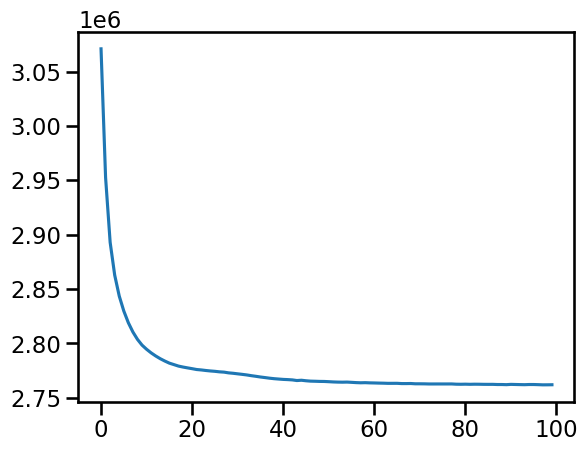

In [13]:
plt.plot(model.history['loss'])

In [14]:
model.calc_all_latent()

latent = model.get_all_latent()

In [17]:
if True:
    latent_barcode = np.array([_.split('~')[1] for _ in latent[1]])
    df_latent = pd.DataFrame(latent[0], index=latent_barcode)
    df_latent.to_csv('./outputs/lymph_modalMatch/res.csv')

else:
    df_latent = pd.read_csv('./outputs/lymph_modalMatch/res.csv', index_col=0)
    df_latent.index = df_latent.index.astype('str')

In [18]:
ad_a1_adt.obsm['X_emb'] = df_latent.loc[ad_a1_adt.obs_names, :].values
ad_d1_rna.obsm['X_emb'] = df_latent.loc[ad_d1_rna.obs_names, :].values
ad_d1_adt.obsm['X_emb'] = df_latent.loc[ad_d1_adt.obs_names, :].values

In [19]:
ad_mosaic = sc.concat([ad_a1_adt, ad_d1_rna, ad_d1_adt])
ad_mosaic = get_umap(ad_mosaic, ['X_emb'])

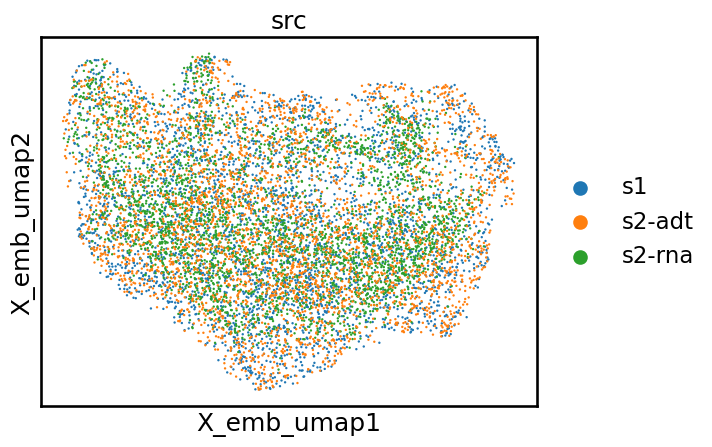

In [20]:
# # plot
wrap_warn_plot(ad_mosaic, 'X_emb_umap', ['src'])

In [21]:
from lisi_bridge import eval_bridge
eval_bridge(
        ad_d1_rna, ad_d1_adt,
        label_key=None,
        batch_key='Sample',
        use_rep='X_emb',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.16342
Match_score=0.00375


{'FOSCTTM': 0.16342483803560454, 'Match_score': 0.0037470249168385593}

In [22]:
# lisi_res = eval_lisi(
#     ad_mosaic,
#     batch_keys=['src'],
#     label_keys = [],
#     use_rep='X_emb', use_neighbors=False,
# )
# lisi_res['src_iLISI'][0]

### batch corr

In [23]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['src'].to_list())
# ad_mosaic = get_umap(ad_mosaic, ['X_emb_har'])
split_ob([ad_a1_adt, ad_d1_rna, ad_d1_adt], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [24]:
eval_bridge(
        ad_d1_rna, ad_d1_adt,
        label_key=None,
        batch_key='Sample',
        use_rep='X_emb_har',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.16761
Match_score=0.00576


{'FOSCTTM': 0.16761211077206256, 'Match_score': 0.005761824428094152}

In [ ]:
# # r1 = eval_ads([ad_mosaic, ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', clust_key)
# lisi_res = eval_lisi(
#     ad_mosaic,
#     batch_keys=['src'],
#     label_keys = [],
#     use_rep='X_emb_har', use_neighbors=False,
# )
# r2 = lisi_res['src_iLISI'][0]

### Vis

In [25]:
# wrap_warn_plot(ad_mosaic, 'X_emb_har_umap', ['src'])

# unify type colors
# mclust_type2dict = dict(zip(ad_mosaic.obs.mclust.cat.categories, ad_mosaic.uns['mclust_colors']))
# label_type2dict = dict(zip(ad_mosaic.obs.Combined_Clusters_annotation.cat.categories, ad_mosaic.uns['Combined_Clusters_annotation_colors']))
# ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
#     [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'mclust', mclust_type2dict)
# ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
#     [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', label_type2dict)

In [26]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/Lymph_modalMatch/cobolt'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=ad_mosaic.obs_names)
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))